In [44]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import json
from datetime import datetime
import re
import csv
from bs4 import BeautifulSoup
import numpy as np

In [2]:
directory = 'data/financial_information'
onlyfiles = [f for f in listdir(directory) if isfile(join(directory, f))]
df = pd.DataFrame(onlyfiles, columns = ['Files'])
df['nr'] = df['Files'].str.split('.',expand=True)[0]
df.nr = df.nr.astype(int)
df.sort_values(["nr"], ignore_index=True, inplace=True)

In [3]:
names = pd.read_csv('data/main/companies.csv',sep='$')
df = df.merge(names, left_on='nr', right_on='Index')
df = df[['Files', 'nr', 'Name des Beihilfeempfängers']]
df

,Files,nr,Name des Beihilfeempfängers
0,1.json,1,K-motion GmbH & Co. KG
1,6.json,6,HGH Hotelgesellschaft mbH
2,7.json,7,Zillertal GmbH
3,8.json,8,Musikreisen Manufaktur GmbH
4,9.json,9,Junges Hotel Hamburg Betriebsgesellschaft mbH
...,...,...,...
40163,120229.json,120229,ESCON Engineering Services and Consulting GmbH
40164,120234.json,120234,Bühnenverleih Frank von Wysocki GmbH
40165,120236.json,120236,Gallissas Theaterverlag und Mediaagentur GmbH
40166,120242.json,120242,Schuite & Schuite Druckfarben GmbH


In [5]:
df = df.drop_duplicates(subset='Name des Beihilfeempfängers', keep="last")

In [6]:
df

,Files,nr,Name des Beihilfeempfängers
7,15.json,15,Manju Berlin GmbH
9,48.json,48,T.u.R. Hotel am Rothenbaum GmbH
15,64.json,64,GH GRUNDINVEST HESSEN GMBH
17,74.json,74,GEORG VEESER GMBH & CO KG
18,75.json,75,CAR-SERVICE RICHTER GMBH
...,...,...,...
40163,120229.json,120229,ESCON Engineering Services and Consulting GmbH
40164,120234.json,120234,Bühnenverleih Frank von Wysocki GmbH
40165,120236.json,120236,Gallissas Theaterverlag und Mediaagentur GmbH
40166,120242.json,120242,Schuite & Schuite Druckfarben GmbH


In [7]:
def return_table(grid, id, company):
    for idx, each_grid in enumerate(grid, start=0):
        grid_a = each_grid.find_all(string = re.compile("A. A"))
        grid_p = each_grid.find_all(string = re.compile("A. E"))
        if  grid_a and grid_p:
            #print(idx,'combined BS', id, company)
            return None #grid[idx]
            break
        if grid_a:
            #print(idx,'Aktiv')
            #aktiv = grid[idx]
            aktiv = idx
            #print(get_total(aktiv))
            continue
        if grid_p:
            #print(idx,'Passiv')
            #passiv = grid[idx]
            passiv = idx
            #print(get_total(passiv))
            continue
        else:
            #return None
            continue
    try:
        #return aktiv, passiv
        return [aktiv, passiv]
    except:
        #print("None", id, company)
        return None 
    
#return_table(grid, id='x', company='xy')

In [20]:
def get_KPI(a, p):
    
    kpi = {
  "current_ratio": "",
  "qick_ratio": "",
  "cash_ratio": "",
  "debt2equity_ratio": "",
  "debt2asset_ratio": "",
  "equity_ratio": ""}
    
    kpi["assets"] = to_float(p['Gesamt'])
    kpi["equity"] = to_float(p['Eigenkapital'])
    kpi['current_ratio'] = current_ratio(a,p)
    kpi['qick_ratio'] = qick_ratio(a,p)
    kpi['cash_ratio'] = cash_ratio(a,p)
    kpi['debt2equity_ratio'] = debt2equity_ratio(a,p)
    kpi['debt2asset_ratio'] = debt2asset_ratio(a,p)
    kpi['equity_ratio'] = equity_ratio(a,p)
    
    return kpi


def current_ratio(aktiv, passiv):
    current_a = aktiv['Umlaufvermögen']
    current_l = passiv['Verbindlichkeiten_kurz']
    if current_l == '' :
        current_l = passiv['Verbindlichkeiten']
    ratio = to_float(current_a) / to_float(current_l)
    return ratio

def qick_ratio(aktiv, passiv):
    current_a = to_float(aktiv['Umlaufvermögen'])
    inventory = to_float(aktiv['Vorräte'])
    current_l = to_float(passiv['Verbindlichkeiten_kurz'])
    if current_l == 0 :
        current_l = to_float(passiv['Verbindlichkeiten'])
    ratio = ( current_a - inventory )  / current_l
    return ratio

def cash_ratio(aktiv, passiv):
    cash = to_float(aktiv['Guthaben'])
    current_l = to_float(passiv['Verbindlichkeiten_kurz'])
    if current_l == 0 :
        current_l = to_float(passiv['Verbindlichkeiten'])
    ratio = cash / current_l
    return ratio

def debt2equity_ratio(aktiv, passiv):
    liabilities = to_float(passiv['Verbindlichkeiten'])
    provisions = to_float(passiv['Rückstellungen'])
    accruals = to_float(passiv['Rechnungsabgrenzungsposten'])
    debt = liabilities + provisions + accruals
    equity = to_float(passiv['Eigenkapital'])
    ratio = debt / equity
    return ratio

def debt2asset_ratio(aktiv, passiv):
    liabilities = to_float(passiv['Verbindlichkeiten'])
    provisions = to_float(passiv['Rückstellungen'])
    accruals = to_float(passiv['Rechnungsabgrenzungsposten'])
    debt = liabilities + provisions + accruals
    total = to_float(passiv['Gesamt'])
    ratio = debt / total
    return ratio

def equity_ratio(aktiv, passiv):
    equity = to_float(passiv['Eigenkapital'])
    total = to_float(passiv['Gesamt'])
    ratio = equity / total
    return ratio

def to_float(a):
    a = a.replace('.','').replace(',','.')
    if a == '':
        a = 0
    return float(a) 

In [8]:
def aktiva_items(data):
    item_aktiva = {
  "Gesamt": "",
  "Anlagevermögen": "",
  "Umlaufvermögen": "",
  "Vorräte": "",
  "Guthaben": ""}
    
    for section in data.find_all('tbody'):
        last_row = section.find_all('tr')[-1:]
        item_aktiva["Gesamt"] = last_row[0].find_all('td')[1].text.strip()

        for line in section.find_all('tr')[:-1]:
            cell_data = []
            for idx, cell in enumerate(line.find_all('td'), start=1):
                cell = cell.text
                if idx == 1:
                    name = cell.split(" ")[1].strip()
                if idx == 2 and "anlagevermögen" in name.lower():
                    item_aktiva["Anlagevermögen"] = cell
                if idx == 2 and "umlaufvermögen" in name.lower():
                    item_aktiva["Umlaufvermögen"] = cell
                if idx == 2 and "vorräte" in name.lower():
                    item_aktiva["Vorräte"] = cell
                if idx == 2 and re.search(r'(kassen|guthaben)', name.lower()):
                    item_aktiva["Guthaben"] = cell
    return(item_aktiva)

def passiva_items(data):
    item_passiva = {
  "Gesamt": "",
  "Eigenkapital": "",
  "Rückstellungen": "",
  "Rechnungsabgrenzungsposten": "",
  "Verbindlichkeiten": "",
  "Verbindlichkeiten_kurz": ""}
    
    for section in data.find_all('tbody'):
        last_row = section.find_all('tr')[-1:]
        item_passiva["Gesamt"] = last_row[0].find_all('td')[1].text.strip()

        for line in section.find_all('tr')[:-1]:
            cell_data = []
            for idx, cell in enumerate(line.find_all('td'), start=1):
                cell = cell.text
                if idx == 1:
                    name = cell.split(" ")[1].strip()
                    full = cell.strip()
                if idx == 2 and "eigenkapital" in name.lower():
                    item_passiva["Eigenkapital"] = cell
                if idx == 2 and "rückstellungen" in name.lower():
                    item_passiva["Rückstellungen"] = cell
                if idx == 2 and "rechnungsabgrenzungsposten" in name.lower():
                    item_passiva["Rechnungsabgrenzungsposten"] = cell
                if idx == 2 and "verbindlichkeiten" in name.lower():
                    item_passiva["Verbindlichkeiten"] = cell
                if idx == 2 and "laufzeit bis" in full.lower():
                    item_passiva["Verbindlichkeiten_kurz"] = cell

    return(item_passiva)

In [108]:
for idy, (File, Name) in enumerate(zip(df.Files, df['Name des Beihilfeempfängers']), start=1):
    if idy < 8:
        print(File , Name)

1.json K-motion GmbH & Co. KG
6.json HGH Hotelgesellschaft mbH
7.json Zillertal GmbH
8.json Musikreisen Manufaktur GmbH
9.json Junges Hotel Hamburg Betriebsgesellschaft mbH
10.json SeaTravel HAM Kreuzfahrten GmbH
14.json BCH Business Club Hamburg GmbH


In [104]:
#new try
def to_float(a):
    a = a.replace('.','').replace(',','.')
    if a == '':
        a = 0
    return float(a) 

all_KPIs = []
for id_company, (File, Name) in enumerate(zip(df.Files, df['Name des Beihilfeempfängers']), start=1):
    if id_company > 0:
        with open('data/financial_information/'+ File) as f:
            data = json.load(f)

            for id_year, item in enumerate(data.keys(), start=1):
                try:
                    if "Konzernabschluss" in item: continue
                    if "Liquidationsschlussbilanz" in item: continue
                    if "\u00a7\u00a7 264 Abs. 3" in item: continue
                    if item == "": continue
                    actual_name = data[item]['company']
                    period_end = re.split(" " , data[item]['name'])[-1]
                    period_start = re.split(" " , data[item]['name'])[-4]
                    report = data[item]['report']
                    soup = BeautifulSoup(report, 'html.parser')
                    grid = soup.findAll('table', attrs={"class":"std_table"})
                    a = return_table(grid, id_year, actual_name)
                    
                    aktiv = grid[a[0]]
                    passiv = grid[a[1]]


                    items_aktiva = aktiva_items(aktiv)                    
                    items_passiva = passiva_items(passiv)

                    export = [actual_name,
                              Name, 
                              period_start,
                              period_end,
                              to_float(items_passiva["Gesamt"]) , 
                              to_float(items_passiva["Eigenkapital"]), 
                              to_float(items_passiva["Rückstellungen"]),
                              to_float(items_passiva["Rechnungsabgrenzungsposten"]),
                              to_float(items_passiva["Verbindlichkeiten"]),
                              to_float(items_passiva["Verbindlichkeiten_kurz"]),
                              to_float(items_aktiva["Anlagevermögen"]),
                              to_float(items_aktiva["Umlaufvermögen"]),
                              to_float(items_aktiva["Vorräte"]),
                              to_float(items_aktiva["Guthaben"])]
                                                  
                    all_KPIs.append(export)
                    

                except Exception as f:
                    None #print(f)

In [111]:
all_kpi = pd.DataFrame(all_KPIs)
#all_kpi['year'] = all_kpi[2].replace(to_replace='[0-9]{2}.[0-9]{2}.', regex=True, value='')
all_kpi

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,T.u.R. Hotel am Rothenbaum GmbH,T.u.R. Hotel am Rothenbaum GmbH,01.04.2020,31.03.2021,731671.83,472267.61,59821.91,0.00,199582.31,10582.31,69862.00,661589.35,0.00,163695.25
1,T.u.R. Hotel am Rothenbaum GmbH,T.u.R. Hotel am Rothenbaum GmbH,01.04.2019,31.03.2020,512694.02,446790.84,40839.34,0.00,25063.84,25063.84,86833.00,425861.02,0.00,37486.08
2,T.u.R. Hotel am Rothenbaum GmbH,T.u.R. Hotel am Rothenbaum GmbH,01.04.2018,31.03.2019,434079.56,393640.05,13896.42,0.00,26543.09,26543.09,101427.00,332652.56,167.00,13961.45
3,T.u.R. Hotel am Rothenbaum GmbH,T.u.R. Hotel am Rothenbaum GmbH,01.04.2017,31.03.2018,406658.13,344784.27,25480.80,0.00,36393.06,36393.06,119571.00,287087.13,220.00,28753.53
4,GH GrundInvest Hessen GmbH,GH GRUNDINVEST HESSEN GMBH,01.01.2020,31.12.2020,2416778.57,192314.61,210730.00,0.00,2013733.96,0.00,44323.00,2372455.57,1021574.17,97459.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83321,Bühnenverleih Frank von Wysocki GmbH,Bühnenverleih Frank von Wysocki GmbH,01.01.2017,31.12.2017,1941506.39,1368628.85,459915.50,0.00,112962.04,112962.04,201355.00,1735399.30,0.00,396219.05
83322,GALLISSAS Theaterverlag und Mediaagentur GmbH,Gallissas Theaterverlag und Mediaagentur GmbH,01.01.2021,31.12.2021,3261572.98,733746.39,33960.82,8934.07,2484931.70,1585649.56,429547.26,2819122.48,4770.00,645699.32
83323,GALLISSAS Theaterverlag und Mediaagentur GmbH,Gallissas Theaterverlag und Mediaagentur GmbH,01.01.2020,31.12.2020,3067134.74,699191.11,11400.00,0.00,2356543.63,1424565.68,447923.26,2607247.66,4770.00,619224.85
83324,GALLISSAS Theaterverlag und Mediaagentur GmbH,Gallissas Theaterverlag und Mediaagentur GmbH,01.01.2019,31.12.2019,3205810.54,685492.00,120061.73,0.00,2400256.81,2171464.22,450837.26,2746513.60,4770.00,254303.94


In [112]:
all_kpi = all_kpi.rename(columns={0:'company',1:'name_matching' ,2:'period_start' , 3:'period_end', 4:'assets', 5:'equity', 6:'accruals', 7:'deferrals', 8:'liabilities', 9:'current_liabilities', 10:'fixed_assets',11:'current_assets',12:'inventories',13:'cash'})

In [113]:
all_kpi

,company,name_matching,period_start,period_end,assets,equity,accruals,deferrals,liabilities,current_liabilities,fixed_assets,current_assets,inventories,cash
0,T.u.R. Hotel am Rothenbaum GmbH,T.u.R. Hotel am Rothenbaum GmbH,01.04.2020,31.03.2021,731671.83,472267.61,59821.91,0.00,199582.31,10582.31,69862.00,661589.35,0.00,163695.25
1,T.u.R. Hotel am Rothenbaum GmbH,T.u.R. Hotel am Rothenbaum GmbH,01.04.2019,31.03.2020,512694.02,446790.84,40839.34,0.00,25063.84,25063.84,86833.00,425861.02,0.00,37486.08
2,T.u.R. Hotel am Rothenbaum GmbH,T.u.R. Hotel am Rothenbaum GmbH,01.04.2018,31.03.2019,434079.56,393640.05,13896.42,0.00,26543.09,26543.09,101427.00,332652.56,167.00,13961.45
3,T.u.R. Hotel am Rothenbaum GmbH,T.u.R. Hotel am Rothenbaum GmbH,01.04.2017,31.03.2018,406658.13,344784.27,25480.80,0.00,36393.06,36393.06,119571.00,287087.13,220.00,28753.53
4,GH GrundInvest Hessen GmbH,GH GRUNDINVEST HESSEN GMBH,01.01.2020,31.12.2020,2416778.57,192314.61,210730.00,0.00,2013733.96,0.00,44323.00,2372455.57,1021574.17,97459.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83321,Bühnenverleih Frank von Wysocki GmbH,Bühnenverleih Frank von Wysocki GmbH,01.01.2017,31.12.2017,1941506.39,1368628.85,459915.50,0.00,112962.04,112962.04,201355.00,1735399.30,0.00,396219.05
83322,GALLISSAS Theaterverlag und Mediaagentur GmbH,Gallissas Theaterverlag und Mediaagentur GmbH,01.01.2021,31.12.2021,3261572.98,733746.39,33960.82,8934.07,2484931.70,1585649.56,429547.26,2819122.48,4770.00,645699.32
83323,GALLISSAS Theaterverlag und Mediaagentur GmbH,Gallissas Theaterverlag und Mediaagentur GmbH,01.01.2020,31.12.2020,3067134.74,699191.11,11400.00,0.00,2356543.63,1424565.68,447923.26,2607247.66,4770.00,619224.85
83324,GALLISSAS Theaterverlag und Mediaagentur GmbH,Gallissas Theaterverlag und Mediaagentur GmbH,01.01.2019,31.12.2019,3205810.54,685492.00,120061.73,0.00,2400256.81,2171464.22,450837.26,2746513.60,4770.00,254303.94


In [114]:
all_kpi['current_liabilities'] = np.where(all_kpi['current_liabilities'] == 0, all_kpi['liabilities'], all_kpi['current_liabilities'])
all_kpi['current_ratio'] = all_kpi['current_assets'] / all_kpi['current_liabilities']
all_kpi['qick_ratio'] = (all_kpi['current_assets'] - all_kpi['inventories'] ) / all_kpi['current_liabilities']
all_kpi['cash_ratio'] =  all_kpi['cash'] / all_kpi['assets']
all_kpi['debt2equity_ratio'] = all_kpi['liabilities'] / all_kpi['equity']
all_kpi['debt2asset_ratio'] = all_kpi['liabilities'] / all_kpi['assets']
all_kpi['equity_ratio'] = all_kpi['equity'] / all_kpi['assets']

In [115]:
all_kpi

,company,name_matching,period_start,period_end,assets,equity,accruals,deferrals,liabilities,current_liabilities,fixed_assets,current_assets,inventories,cash,current_ratio,qick_ratio,cash_ratio,debt2equity_ratio,debt2asset_ratio,equity_ratio
0,T.u.R. Hotel am Rothenbaum GmbH,T.u.R. Hotel am Rothenbaum GmbH,01.04.2020,31.03.2021,731671.83,472267.61,59821.91,0.00,199582.31,10582.31,69862.00,661589.35,0.00,163695.25,62.518425,62.518425,0.223728,0.422604,0.272776,0.645464
1,T.u.R. Hotel am Rothenbaum GmbH,T.u.R. Hotel am Rothenbaum GmbH,01.04.2019,31.03.2020,512694.02,446790.84,40839.34,0.00,25063.84,25063.84,86833.00,425861.02,0.00,37486.08,16.991052,16.991052,0.073116,0.056097,0.048887,0.871457
2,T.u.R. Hotel am Rothenbaum GmbH,T.u.R. Hotel am Rothenbaum GmbH,01.04.2018,31.03.2019,434079.56,393640.05,13896.42,0.00,26543.09,26543.09,101427.00,332652.56,167.00,13961.45,12.532548,12.526257,0.032163,0.067430,0.061148,0.906838
3,T.u.R. Hotel am Rothenbaum GmbH,T.u.R. Hotel am Rothenbaum GmbH,01.04.2017,31.03.2018,406658.13,344784.27,25480.80,0.00,36393.06,36393.06,119571.00,287087.13,220.00,28753.53,7.888513,7.882468,0.070707,0.105553,0.089493,0.847848
4,GH GrundInvest Hessen GmbH,GH GRUNDINVEST HESSEN GMBH,01.01.2020,31.12.2020,2416778.57,192314.61,210730.00,0.00,2013733.96,2013733.96,44323.00,2372455.57,1021574.17,97459.91,1.178138,0.670834,0.040326,10.471040,0.833231,0.079575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83321,Bühnenverleih Frank von Wysocki GmbH,Bühnenverleih Frank von Wysocki GmbH,01.01.2017,31.12.2017,1941506.39,1368628.85,459915.50,0.00,112962.04,112962.04,201355.00,1735399.30,0.00,396219.05,15.362677,15.362677,0.204078,0.082537,0.058183,0.704931
83322,GALLISSAS Theaterverlag und Mediaagentur GmbH,Gallissas Theaterverlag und Mediaagentur GmbH,01.01.2021,31.12.2021,3261572.98,733746.39,33960.82,8934.07,2484931.70,1585649.56,429547.26,2819122.48,4770.00,645699.32,1.777898,1.774889,0.197972,3.386636,0.761881,0.224967
83323,GALLISSAS Theaterverlag und Mediaagentur GmbH,Gallissas Theaterverlag und Mediaagentur GmbH,01.01.2020,31.12.2020,3067134.74,699191.11,11400.00,0.00,2356543.63,1424565.68,447923.26,2607247.66,4770.00,619224.85,1.830205,1.826857,0.201890,3.370386,0.768321,0.227962
83324,GALLISSAS Theaterverlag und Mediaagentur GmbH,Gallissas Theaterverlag und Mediaagentur GmbH,01.01.2019,31.12.2019,3205810.54,685492.00,120061.73,0.00,2400256.81,2171464.22,450837.26,2746513.60,4770.00,254303.94,1.264821,1.262624,0.079326,3.501510,0.748721,0.213828


In [120]:
all_kpi['year'] = all_kpi['period_end'].replace(to_replace='[0-9]{2}.[0-9]{2}.', regex=True, value='')

all_kpi = all_kpi[~all_kpi['year'].str.contains("Liquidationsschlussbilanz")]

all_kpi['year'] = all_kpi['year'].apply(int)
all_kpi

/var/folders/nr/94zdnpbn2xj3pwc_d9lfk0cw0000gn/T/ipykernel_50684/3307077625.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_kpi['year'] = all_kpi['year'].apply(int)


,company,name_matching,period_start,period_end,assets,equity,accruals,deferrals,liabilities,current_liabilities,...,current_assets,inventories,cash,current_ratio,qick_ratio,cash_ratio,debt2equity_ratio,debt2asset_ratio,equity_ratio,year
0,T.u.R. Hotel am Rothenbaum GmbH,T.u.R. Hotel am Rothenbaum GmbH,01.04.2020,31.03.2021,731671.83,472267.61,59821.91,0.00,199582.31,10582.31,...,661589.35,0.00,163695.25,62.518425,62.518425,0.223728,0.422604,0.272776,0.645464,2021
1,T.u.R. Hotel am Rothenbaum GmbH,T.u.R. Hotel am Rothenbaum GmbH,01.04.2019,31.03.2020,512694.02,446790.84,40839.34,0.00,25063.84,25063.84,...,425861.02,0.00,37486.08,16.991052,16.991052,0.073116,0.056097,0.048887,0.871457,2020
2,T.u.R. Hotel am Rothenbaum GmbH,T.u.R. Hotel am Rothenbaum GmbH,01.04.2018,31.03.2019,434079.56,393640.05,13896.42,0.00,26543.09,26543.09,...,332652.56,167.00,13961.45,12.532548,12.526257,0.032163,0.067430,0.061148,0.906838,2019
3,T.u.R. Hotel am Rothenbaum GmbH,T.u.R. Hotel am Rothenbaum GmbH,01.04.2017,31.03.2018,406658.13,344784.27,25480.80,0.00,36393.06,36393.06,...,287087.13,220.00,28753.53,7.888513,7.882468,0.070707,0.105553,0.089493,0.847848,2018
4,GH GrundInvest Hessen GmbH,GH GRUNDINVEST HESSEN GMBH,01.01.2020,31.12.2020,2416778.57,192314.61,210730.00,0.00,2013733.96,2013733.96,...,2372455.57,1021574.17,97459.91,1.178138,0.670834,0.040326,10.471040,0.833231,0.079575,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83321,Bühnenverleih Frank von Wysocki GmbH,Bühnenverleih Frank von Wysocki GmbH,01.01.2017,31.12.2017,1941506.39,1368628.85,459915.50,0.00,112962.04,112962.04,...,1735399.30,0.00,396219.05,15.362677,15.362677,0.204078,0.082537,0.058183,0.704931,2017
83322,GALLISSAS Theaterverlag und Mediaagentur GmbH,Gallissas Theaterverlag und Mediaagentur GmbH,01.01.2021,31.12.2021,3261572.98,733746.39,33960.82,8934.07,2484931.70,1585649.56,...,2819122.48,4770.00,645699.32,1.777898,1.774889,0.197972,3.386636,0.761881,0.224967,2021
83323,GALLISSAS Theaterverlag und Mediaagentur GmbH,Gallissas Theaterverlag und Mediaagentur GmbH,01.01.2020,31.12.2020,3067134.74,699191.11,11400.00,0.00,2356543.63,1424565.68,...,2607247.66,4770.00,619224.85,1.830205,1.826857,0.201890,3.370386,0.768321,0.227962,2020
83324,GALLISSAS Theaterverlag und Mediaagentur GmbH,Gallissas Theaterverlag und Mediaagentur GmbH,01.01.2019,31.12.2019,3205810.54,685492.00,120061.73,0.00,2400256.81,2171464.22,...,2746513.60,4770.00,254303.94,1.264821,1.262624,0.079326,3.501510,0.748721,0.213828,2019


In [121]:
all_kpi.to_csv('data/main/company_KPIs.csv', encoding='utf-8', index=False)

In [113]:
# old try
all_KPIs = []
for id_1, (File, Name) in enumerate(zip(df.Files, df['Name des Beihilfeempfängers']), start=1):
    if id_1 > 0:
        with open('data/financial_information/'+ File) as f:
            data = json.load(f)

            for id_2, item in enumerate(data.keys(), start=1):
                try:
                    if "Konzernabschluss" in item: continue
                    if "\u00a7\u00a7 264 Abs. 3" in item: continue
                    if item == "": continue
                    actual_name = data[item]['company']
                    year = re.split(" " , data[item]['name'])[-1]
                    report = data[item]['report']
                    soup = BeautifulSoup(report, 'html.parser')
                    grid = soup.findAll('table', attrs={"class":"std_table"})
                    a = return_table(grid, id_2, actual_name)
                    aktiv = grid[a[0]]
                    #print(aktiva_items(aktiv))
                    #aktiv_t = get_total(aktiv)
                    passiv = grid[a[1]]
                    #print(passiva_items(passiv))
                    #passiv_t = get_total(passiv)
                    #all_level_1.extend(get_level_1(passiv))
                    
                    kpi = get_KPI(aktiva_items(aktiv), passiva_items(passiv)) 

                    export = [actual_name, 
                              year , 
                              kpi["assets"] , 
                              kpi["equity"], 
                              kpi["current_ratio"],
                              kpi["qick_ratio"],
                              kpi["cash_ratio"],
                              kpi["debt2equity_ratio"],
                              kpi["debt2asset_ratio"],
                              kpi["equity_ratio"],
                              Name]
                                                  
                    all_KPIs.append(export)
                    

                except Exception as f:
                    None #print(f)

In [110]:
all_kpi = pd.DataFrame(all_KPIs)

all_kpi

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,T.u.R. Hotel am Rothenbaum GmbH,T.u.R. Hotel am Rothenbaum GmbH,01.04.2020,31.03.2021,731671.83,472267.61,59821.91,0.00,199582.31,10582.31,69862.00,661589.35,0.00,163695.25
1,T.u.R. Hotel am Rothenbaum GmbH,T.u.R. Hotel am Rothenbaum GmbH,01.04.2019,31.03.2020,512694.02,446790.84,40839.34,0.00,25063.84,25063.84,86833.00,425861.02,0.00,37486.08
2,T.u.R. Hotel am Rothenbaum GmbH,T.u.R. Hotel am Rothenbaum GmbH,01.04.2018,31.03.2019,434079.56,393640.05,13896.42,0.00,26543.09,26543.09,101427.00,332652.56,167.00,13961.45
3,T.u.R. Hotel am Rothenbaum GmbH,T.u.R. Hotel am Rothenbaum GmbH,01.04.2017,31.03.2018,406658.13,344784.27,25480.80,0.00,36393.06,36393.06,119571.00,287087.13,220.00,28753.53
4,GH GrundInvest Hessen GmbH,GH GRUNDINVEST HESSEN GMBH,01.01.2020,31.12.2020,2416778.57,192314.61,210730.00,0.00,2013733.96,0.00,44323.00,2372455.57,1021574.17,97459.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83321,Bühnenverleih Frank von Wysocki GmbH,Bühnenverleih Frank von Wysocki GmbH,01.01.2017,31.12.2017,1941506.39,1368628.85,459915.50,0.00,112962.04,112962.04,201355.00,1735399.30,0.00,396219.05
83322,GALLISSAS Theaterverlag und Mediaagentur GmbH,Gallissas Theaterverlag und Mediaagentur GmbH,01.01.2021,31.12.2021,3261572.98,733746.39,33960.82,8934.07,2484931.70,1585649.56,429547.26,2819122.48,4770.00,645699.32
83323,GALLISSAS Theaterverlag und Mediaagentur GmbH,Gallissas Theaterverlag und Mediaagentur GmbH,01.01.2020,31.12.2020,3067134.74,699191.11,11400.00,0.00,2356543.63,1424565.68,447923.26,2607247.66,4770.00,619224.85
83324,GALLISSAS Theaterverlag und Mediaagentur GmbH,Gallissas Theaterverlag und Mediaagentur GmbH,01.01.2019,31.12.2019,3205810.54,685492.00,120061.73,0.00,2400256.81,2171464.22,450837.26,2746513.60,4770.00,254303.94


In [115]:
kpi_adj = all_kpi[all_kpi[4] > 0 ]
kpi_adj = kpi_adj[kpi_adj[4] < 15 ]
kpi_adj = kpi_adj[kpi_adj[5] > 0 ]
kpi_adj = kpi_adj[kpi_adj[5] < 19 ]
kpi_adj = kpi_adj[kpi_adj[6] > 0 ]
kpi_adj = kpi_adj[kpi_adj[6] < 4 ]
kpi_adj = kpi_adj[kpi_adj[7] > 0 ]
kpi_adj = kpi_adj[kpi_adj[7] < 50 ]
kpi_adj

,0,1,2,3,4,5,6,7,8,9,10
1,Zillertal GmbH,2020,7607535.72,4841744.70,1.910493,1.909975,0.418534,0.571239,0.363559,0.636441,Zillertal GmbH
2,Zillertal GmbH,2019,8505349.91,5265088.15,1.342073,1.341268,0.421875,0.615424,0.380967,0.619033,Zillertal GmbH
3,Zillertal GmbH,2018,8805104.33,5212040.17,1.159419,1.159419,0.357536,0.689378,0.408066,0.591934,Zillertal GmbH
4,Zillertal GmbH,2017,9332628.29,5201623.56,1.110360,1.110360,0.335367,0.794176,0.442641,0.557359,Zillertal GmbH
6,Musikreisen Manufaktur GmbH,2020,571045.24,364066.46,9.055492,9.055492,3.723423,0.568519,0.362456,0.637544,Musikreisen Manufaktur GmbH
...,...,...,...,...,...,...,...,...,...,...,...
72118,Möschlitzer Agrar GmbH,2021,7853156.56,1905636.37,0.554566,0.491507,0.073642,3.019934,0.732813,0.242659,Möschlitzer Agrar GmbH
72119,Möschlitzer Agrar GmbH,2020,8402715.90,1899137.08,0.543835,0.487114,0.061558,3.306814,0.747388,0.226015,Möschlitzer Agrar GmbH
72120,Möschlitzer Agrar GmbH,2018,5554190.75,2448336.57,0.388395,0.253395,0.122428,1.141255,0.503075,0.440809,Möschlitzer Agrar GmbH
72121,Milchproduktion Kreinitz GmbH,2021,4091273.46,175280.62,0.912292,0.566302,0.000103,22.341277,0.957157,0.042843,Milchproduktion Kreinitz GmbH


In [116]:
kpi_adj[1] = kpi_adj[1].apply(int)
all_kpi[1] = all_kpi[1].replace(to_replace='[0-9]{2}.[0-9]{2}.', regex=True, value='')
kpi_adj.to_csv('data/main/company_KPIs.csv', encoding='utf-8', index=False)

In [59]:
kpi_adj[1] = kpi_adj[1].apply(int)
kpi_1920 = kpi_adj.loc[kpi_adj[1].between(2019,2020)]
kpi_1920 = kpi_1920.groupby(0).filter(lambda x : len(x)==2)

In [60]:
kpi_1920

,0,1,2,3,4,5,6,7,8,9
15,BCH Business Club Hamburg GmbH,2020,1405896.27,202474.44,2.012168,1.981305,0.544695,5.943574,0.855982,0.144018
17,Arcade-Hostel GmbH,2019,430010.06,59938.92,0.298675,0.297298,0.233645,6.174138,0.860610,0.139390
31,GH GrundInvest Hessen GmbH,2020,2416778.57,192314.61,1.178138,0.670834,0.048398,11.566797,0.920425,0.079575
32,GH GrundInvest Hessen GmbH,2019,2157298.95,60730.99,1.086721,0.567971,0.003558,34.522210,0.971849,0.028151
42,AS-Drucklufttechnik GmbH,2020,865232.79,322476.19,4.131211,2.136386,0.069057,1.683090,0.627295,0.372705
...,...,...,...,...,...,...,...,...,...,...
72104,MARO Entertainment GmbH,2020,2972912.59,435596.57,1.043187,0.493314,0.031493,5.824922,0.853478,0.146522
72110,by Riese GmbH & Co. KG,2020,1640549.36,1229096.42,3.564650,0.717421,0.017104,0.334761,0.250802,0.749198
72111,by Riese GmbH & Co. KG,2019,1490324.35,1239657.34,7.424714,2.776208,0.613099,0.202207,0.168196,0.831804
72114,Saaleblick Agrar GmbH Gräfenwarth,2020,2990606.05,591837.85,0.431386,0.342247,0.005597,4.024574,0.796459,0.197899


In [61]:
kpi_1920.reset_index()

,index,0,1,2,3,4,5,6,7,8,9
0,15,BCH Business Club Hamburg GmbH,2020,1405896.27,202474.44,2.012168,1.981305,0.544695,5.943574,0.855982,0.144018
1,17,Arcade-Hostel GmbH,2019,430010.06,59938.92,0.298675,0.297298,0.233645,6.174138,0.860610,0.139390
2,31,GH GrundInvest Hessen GmbH,2020,2416778.57,192314.61,1.178138,0.670834,0.048398,11.566797,0.920425,0.079575
3,32,GH GrundInvest Hessen GmbH,2019,2157298.95,60730.99,1.086721,0.567971,0.003558,34.522210,0.971849,0.028151
4,42,AS-Drucklufttechnik GmbH,2020,865232.79,322476.19,4.131211,2.136386,0.069057,1.683090,0.627295,0.372705
...,...,...,...,...,...,...,...,...,...,...,...
18399,72104,MARO Entertainment GmbH,2020,2972912.59,435596.57,1.043187,0.493314,0.031493,5.824922,0.853478,0.146522
18400,72110,by Riese GmbH & Co. KG,2020,1640549.36,1229096.42,3.564650,0.717421,0.017104,0.334761,0.250802,0.749198
18401,72111,by Riese GmbH & Co. KG,2019,1490324.35,1239657.34,7.424714,2.776208,0.613099,0.202207,0.168196,0.831804
18402,72114,Saaleblick Agrar GmbH Gräfenwarth,2020,2990606.05,591837.85,0.431386,0.342247,0.005597,4.024574,0.796459,0.197899


In [79]:
kpi_1920.to_csv('data/main/company_KPIs.csv', encoding='utf-8', index=False)


In [66]:
kpi_1920.to_excel("kpi.xlsx")  

In [62]:
kpi_1920.groupby(1).mean()

/var/folders/nr/94zdnpbn2xj3pwc_d9lfk0cw0000gn/T/ipykernel_12154/3928234087.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  kpi_1920.groupby(1).mean()


,2,3,4,5,6,7,8,9
1,,,,,,,,
2019,2.052023e+06,705559.017987,1.937786,1.438952,0.47190,4.853651,0.661066,0.330066
2020,2.278281e+06,755271.249401,2.443597,1.855514,0.61649,5.374153,0.682546,0.308588


In [63]:
import numpy as np
from scipy import stats

In [ ]:
kpi_1920[(np.abs(stats.zscore(kpi_1920)) < 0.5).all(axis=1)].hist(color='k', alpha=0.5, bins=20)

<Axes: >

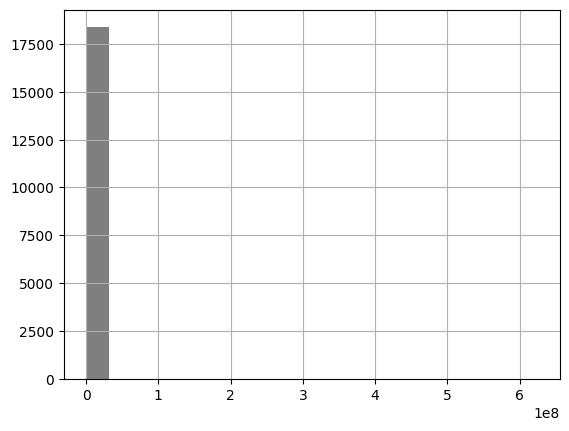

In [77]:
kpi_1920[2].hist(color='k', alpha=0.5, bins=20)